# Upload pickled audio features and merge with metadata

Purpose of this notebook:
1. Upload the audio features from features.pickle
2. Add to the metadata the fileName of the corresponding audio file
3. Merge the metadata and the audio features (for talks for which audio is available)

In [3]:
%matplotlib inline
import numpy as np
from scipy import stats

import glob2 as glob
import pydub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit as ti
import time as time
import aux_code.functions as mfc # user-created functions (re-start kernel to update)
import pickle 


## Upload enhanced metadata

In [34]:
# read metadata (this is the enhanced metadata)
df = pd.read_csv('data/meta_plus.csv', index_col = 0)
#df.index.name = 'Id'
print(df.shape)

(2571, 51)


In [35]:
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'link', 'annualTED', 'film_year', 'published_year',
       'num_speaker_talks', 'technology', 'science', 'global issues',
       'culture', 'design', 'business', 'entertainment', 'health',
       'innovation', 'society', 'Fascinating', 'Courageous', 'Longwinded',
       'Obnoxious', 'Jaw-dropping', 'Inspiring', 'OK', 'Beautiful', 'Funny',
       'Unconvincing', 'Ingenious', 'Informative', 'Confusing', 'Persuasive',
       'wpm', 'words_per_min', 'first_name', 'gender_name',
       'gender_name_class'],
      dtype='object')

## Upload extracted audio features

For when I don't already have the features in memory and want to re-use extracted features saved to file.

In [36]:
# Import audio features data from pickled dictionary file
suffix = '240'
features = {}
featureTime = {}
skippedList = []

for objName in ['features', 'featureTime', 'skippedList']:  
    fileName = 'data/'+objName+suffix+'.pickle'
    print(fileName)
    with open(fileName, 'rb') as handle:
        globals()[objName] = pickle.load(handle)
        print(len(globals()[objName]))

allWav = list(features.keys())
print(len(allWav), allWav[-3:])

data/features240.pickle
1486
data/featureTime240.pickle
1486
data/skippedList240.pickle
14
1486 ['YvesBehar_2008', 'YvesBehar_2009', 'YvesRossy_2011G']


## Match audio filenames and metadata

In [44]:
allMatchesD = {}
duplicates = []

# go through 
for ix, row in df[['title','main_speaker','film_year']].iterrows() :
    #approxNames is based on the metadata
    #wavNames are the audio file names
    approxName = row['main_speaker'].replace(' ','') +'_'+ str(row['film_year'])
    approxName = approxName.replace('.','').replace("'","")
    match = [wavName for wavName in allWav if wavName.startswith( approxName ) ]
    #if match was found
    if len(match)>0: 
        allMatchesD[row['title']] = match[0]
    # if more than one match was found
    if len(match)>1: 
        duplicates.extend(match[1:])

duplicates = sorted(list(set(duplicates)))
df['fileName'] = df['title'].map(allMatchesD)
allMatches = list(allMatchesD.values())
print('number talks with metadata and audio:',len(allMatches))

number talks with metadata and audio: 1317


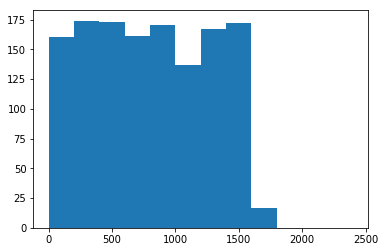

In [39]:
# make histogram of index numbers of talks with an audio file
plt.hist(df[~df.fileName.isna()].index, bins=range(0,2500,200));

count    1331.000000
mean     2009.459053
std         2.968065
min      1984.000000
25%      2008.000000
50%      2010.000000
75%      2012.000000
max      2013.000000
Name: film_year, dtype: float64

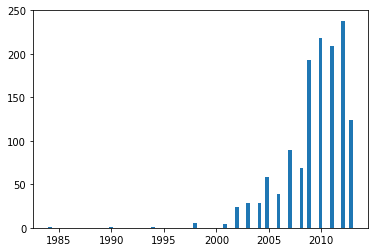

In [41]:
# histogram of film_year for talks with audio
# audio files are from 1984-2013, with most from around 2009.
plt.hist(df[~df.fileName.isna()]['film_year'], bins = 80);

df[~df.fileName.isna()]['film_year'].describe()

# Merge metadata and audio features

In [45]:
# Make sure that df contains fileName
df.columns.get_loc('fileName')

51

In [52]:
# Create a df with filename and all the audio features
# This can take one or multiple sets of audio features for each filename

audioTempDf = pd.DataFrame( columns = [str(num) for num in range(0,34)])
audioTempDf.insert(0,'fileName', features.keys())

for ii, fileName in enumerate(features.keys()):
    vals1 = [float(num[0]) for num in features[fileName].tolist()]
    audioTempDf.iloc[ii,:] = [fileName]+vals1

audioTempDf = audioTempDf.apply(lambda x: list(x))  # this prevents distplot ValueError: color kwarg... (usually from giving a 2D array instead of 1D array)

In [53]:
# Give informative names to audio features

oldNames = [str(item) for item in range(0,34)]

newNames = ['ZCR', 'Energy','EnergyEntropy','SpectralCentroid',
            'SpectralSpread', 'SpectralEntropy','SpectralFlux', 
            'SpectralRollof', 
            'mfcc1','mfcc2','mfcc3','mfcc4',
            'mfccC5','mfcc6','mfcc7','mfcc8',
            'mfcc9','mfcc10','mfcc11','mfcc12', 'mfcc13',
            'Chroma1','Chroma2','Chroma3','Chroma4',
            'Chroma5','Chroma6','Chroma7','Chroma8',
            'Chroma9','Chroma10','Chroma11','Chroma12',
            'Chroma_std']  

namePairs = dict(zip(oldNames, newNames)) #could add different suffixes here
audioTempDf = audioTempDf.rename(columns=namePairs)   

In [54]:
audioTempDf.head(3)

,fileName,ZCR,Energy,EnergyEntropy,SpectralCentroid,SpectralSpread,SpectralEntropy,SpectralFlux,SpectralRollof,mfcc1,...,Chroma4,Chroma5,Chroma6,Chroma7,Chroma8,Chroma9,Chroma10,Chroma11,Chroma12,Chroma_std
0,911Mothers_2010W,0.113023,0.005754,3.277327,0.189827,0.227724,0.822557,0.0,0.120413,-12.967692,...,3.503195e-08,2.970013e-08,1.982383e-08,2.069485e-08,2.393984e-08,1.124012e-08,2.649578e-08,1.287873e-08,1.966733e-08,7.136251e-09
1,AaronHuey_2010X,0.176971,0.009682,3.313197,0.269473,0.241285,1.752903,0.0,0.314532,-11.446232,...,5.095977e-08,1.899055e-08,3.315040e-08,2.607080e-08,3.798238e-08,5.000089e-08,2.155842e-08,3.693945e-08,6.345455e-08,1.378009e-08
2,AaronKoblin_2011,0.119979,0.009615,3.311190,0.173705,0.211600,0.536709,0.0,0.093470,-12.408212,...,2.433533e-08,3.022070e-08,4.342009e-08,6.222283e-08,3.830729e-08,2.239378e-08,7.400433e-08,4.938212e-08,7.607457e-08,2.095060e-08


## Merge metadata and audioTempDf

In [55]:
#Merge audio with metadata df
mergedDf = pd.merge(df, audioTempDf, on='fileName')
print(mergedDf.shape)
mergedDf.head(1)

(1331, 86)


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,Chroma4,Chroma5,Chroma6,Chroma7,Chroma8,Chroma9,Chroma10,Chroma11,Chroma12,Chroma_std
0,265,With the same humor and humanity he exuded in ...,16.3,TED2006,24-02-2006,43,Al Gore,Al Gore: Averting the climate crisis,1,26-06-2006,...,4.634894e-09,4.745749e-09,6.511980e-09,1.140154e-08,1.409230e-09,6.197927e-09,5.474536e-09,5.192200e-09,8.241688e-09,2.768378e-09


# Write to file

In [56]:
# This data is meta and audio
mergedDf.to_csv('data/meta_audio.csv')

In [58]:
mergedDf.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'link', 'annualTED', 'film_year', 'published_year',
       'num_speaker_talks', 'technology', 'science', 'global issues',
       'culture', 'design', 'business', 'entertainment', 'health',
       'innovation', 'society', 'Fascinating', 'Courageous', 'Longwinded',
       'Obnoxious', 'Jaw-dropping', 'Inspiring', 'OK', 'Beautiful', 'Funny',
       'Unconvincing', 'Ingenious', 'Informative', 'Confusing', 'Persuasive',
       'wpm', 'words_per_min', 'first_name', 'gender_name',
       'gender_name_class', 'fileName', 'ZCR', 'Energy', 'EnergyEntropy',
       'SpectralCentroid', 'SpectralSpread', 'SpectralEntropy', 'SpectralFlux',
       'SpectralRollof', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfccC5', 'mfcc6',
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', '

# Summary

meta_audio.csv contains all the metadata, enhanced with several new features, and all the audio features for all the available audio files. 

The audio features come from 4 minute audio segments of each talk.

The transcripts are at 'data/ted-talks/transcripts.csv' and can be matched with the rest of the data based on the 'url' column.